In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_along_river_using_fmm,
                     get_distance_segments,
                     get_undirected_river_network,
                     direct_river_network_using_distance,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     apply_func_to_superpixels,
                     get_array_from_features,
                     get_width_features_from_segments,
                     add_flow_attributes,
                     change_tuples_to_vector,
                     get_geopandas_features_from_array,
                     get_RAG_neighbors,
                     get_segment_df,
                     get_width_features_from_segments,
                     get_geo_width_df,
                     update_graph_with_geometric_width_data,
                     add_width_features_to_graph,
                     update_graph_with_widths
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point, LineString, MultiLineString, GeometryCollection
from shapely.ops import unary_union
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects
from rasterio import features
from tqdm import tqdm
from rasterio.transform import rowcol

# Initialize Paths for Data And Output

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Read Data

In [4]:
with rasterio.open(products_for_map_dir/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    transform = ds.transform
transform

Affine(25.0, 0.0, 640825.0,
       0.0, -25.0, 3285225.0)

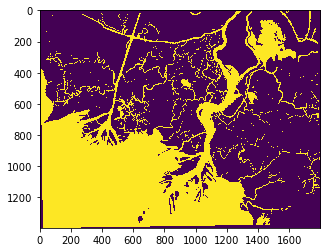

In [5]:
plt.imshow(water_mask)

In [6]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

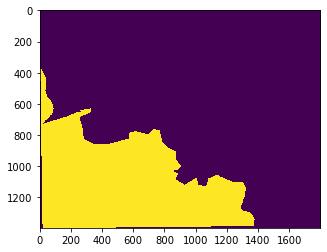

In [7]:
plt.imshow(ocean_mask)

We are going to get the resolution distance in the upper right corner (origin). Of course, this is not valid through the entire raster. The fast-marching method will use this `dx, dy` to approximate distance to our initialization mask (namely the ocean). We will update this distance at the end.

In [8]:
dx, dy = transform.a, -transform.e
dx, dy

(25.0, 25.0)

In [9]:
dist = get_distance_along_river_using_fmm(water_mask,
                                          ocean_mask,
                                          dx=dx,
                                          dy=dy,
                                          # removes areas with less than 2.5% of total size
                                          area_threshold=.025
                                          )

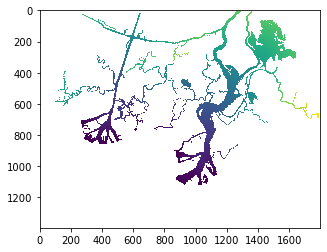

In [10]:
plt.imshow(dist)

We write the distance raster.

In [11]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'distance.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

We threshold the distance according to some number of pixels - below we use `pixel_step`.

In [12]:
pixel_step = 10

segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy)

rag neighbors: 100%|██████████| 102/102 [00:00<00:00, 13216.12it/s]


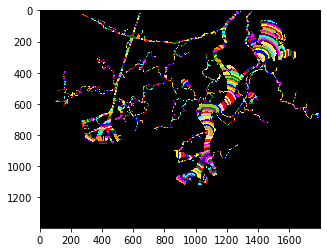

In [13]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb)

In [14]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

In [15]:
p = profile.copy()
p['dtype'] = 'float32'
p['count'] = 3

with rasterio.open(products_for_map_dir/'segments_rgb.tif', 'w', **p) as ds:
    ds.write(segments_rgb.transpose([2, 0, 1]).astype(np.float32))

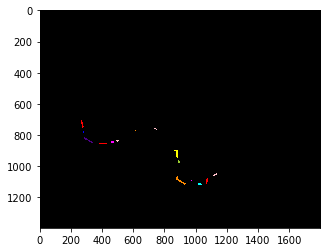

In [16]:
segment_interface_slice = np.isin(segments, interface_adj_segments)
segments_along_interface = segments.copy()
segments_along_interface[~segment_interface_slice] = 0

# To get same color scheme from above
ind = (segments_along_interface != 0)
interface_rgb = np.zeros(segments_rgb.shape)
interface_rgb[ind] = segments_rgb[ind]
plt.imshow(interface_rgb)

In [17]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments_along_interface.tif', 'w', **p) as ds:
    ds.write(segments_along_interface.astype(np.int32), 1)

# Making an Undirected Network

In [18]:
rivG_undirected = get_undirected_river_network(segments, dist, profile, interface_adj_segments)

adding edges: 100%|██████████| 1448/1448 [00:00<00:00, 23748.24it/s]


In [19]:
type(rivG_undirected)

networkx.classes.graph.Graph

In [20]:
node_data =dict(rivG_undirected.nodes(data=True))
random.choice(list(node_data.items()))

((644233.6666666666, 3270660.3333333335),
 {'label': 895,
  'meters_to_interface': 21604.146484375,
  'x': 644233.6666666666,
  'y': 3270660.3333333335,
  'interface_adj': False})

In [21]:
edge_data =(rivG_undirected.edges(data=True))
edge_data = {(e[0], e[1]): e[2] for e in edge_data}
random.choice(list(edge_data.items()))

(((677952.6909334525, 3279753.9079946405),
  (677677.9782082324, 3279729.6489104116)),
 {'length_m': 275.7817698206901, 'weight': 275.7817698206901})

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


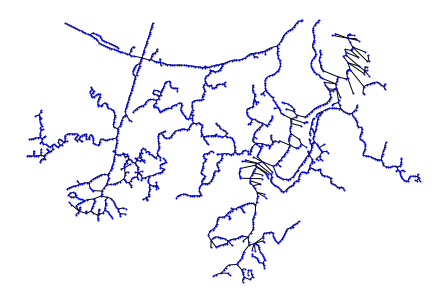

In [22]:
pos = {node: node for node in node_data.keys()}
nx.draw(rivG_undirected, 
        pos=pos, 
        node_size=1, 
        node_color='blue')
plt.show()

In [23]:
rivG = direct_river_network_using_distance(rivG_undirected, 
                                           remove_danlging_segments=True, 
                                           segment_threshold=3,
                                           meters_to_interface_filter_buffer=1_000,
                                          )

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


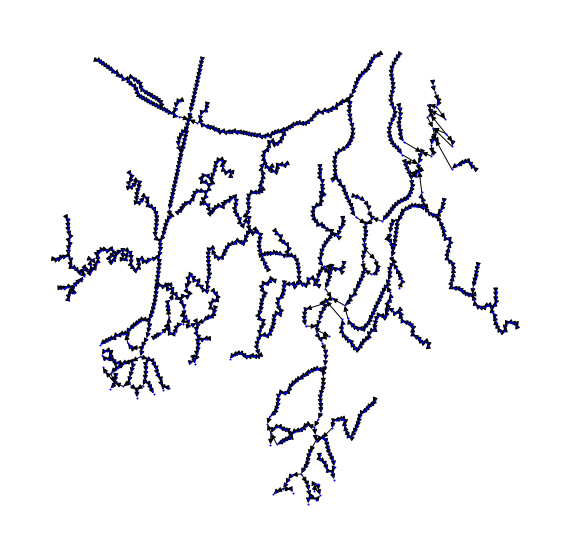

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(rivG, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

Once these are exported to `geojson` format below - we can view these including the arrows as indicated [here](https://gis.stackexchange.com/a/215842/114646).

In [25]:
df_edges = export_edges_to_geodataframe(rivG, profile['crs'])
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,238.516385,238.516385,0,10,0,LINESTRING (649898.4693877551 3267811.32653061...
1,255.181139,255.181139,0,10,0,LINESTRING (649661.0745614035 3267834.42982456...
2,252.497707,252.497707,0,10,0,LINESTRING (649408.8157894737 3267795.92105263...
3,266.893075,266.893075,0,10,0,LINESTRING (649169.3681318681 3267715.79670329...
4,244.409188,244.409188,0,10,0,LINESTRING (648904.5138888889 3267682.87037037...


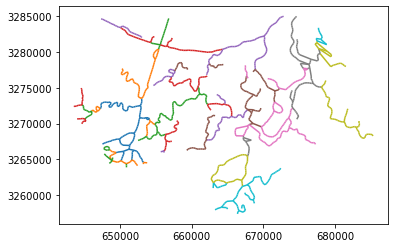

In [26]:
df_edges.plot(column='segment_id', categorical=True)

# Draw Interface Sink

We are going to add a node in the middle of the ocean that will can be visualized as a sink.

In [27]:
ocean_centroid = get_map_centroid_from_binary_mask(ocean_mask, profile)
ocean_centroid

(654489.7191008729, 3257678.169107866)

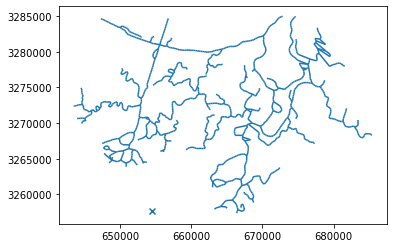

In [28]:
fig, ax = plt.subplots()
df_ocean_centroid = gpd.GeoDataFrame(geometry=[Point(ocean_centroid)],
                                     crs={'init':'epsg:4326'})
df_edges.plot(ax=ax)
df_ocean_centroid.plot(ax=ax, marker='x')

In [29]:
connected_to_interface = [node for node in rivG.nodes() if (rivG.nodes[node]['interface_adj'])]
rivG_sink = rivG.copy()

edge_data_to_interface = {(node, ocean_centroid): {'weight': 0,
                                                   'meters_to_interface': 0} for node in connected_to_interface}

rivG_sink.add_edges_from(edge_data_to_interface.keys())

nx.set_edge_attributes(rivG_sink, edge_data_to_interface)

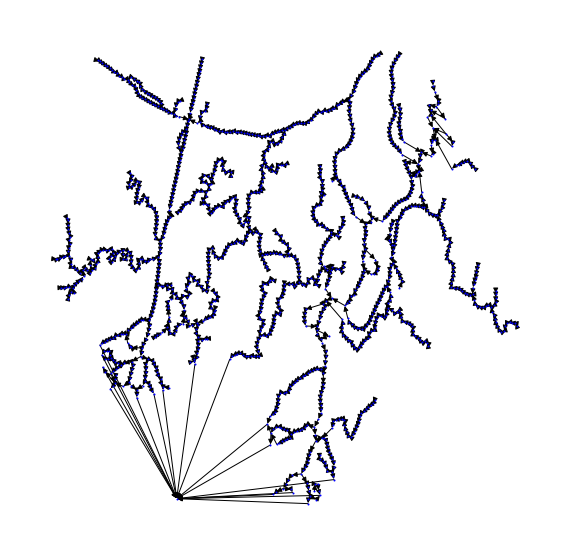

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
pos[ocean_centroid] = ocean_centroid

nx.draw(rivG_sink, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

# Including Widths

The basic approach is as follows:
1. We determine the approximate flow of water and consider a candidate width geometry being $\perp$ to this flow.
2. We then considered a the segment of the particular node and its neighborsm with respect to the RAG and intersect this candidate width geometry with this area.

**For 1**, we use the gradient of our distance function $\varphi$ from the fmm when available. However, the gradient is only defined within the channels and due to the concavity of the segments, the node itself may actually lie on an channel island or slightly on land.

Therefore, we use the network structure that adapts the methodology of [RivWidth](http://uncglobalhydrology.org/rivwidth/) for those with undefined gradient. Specifically, we consider all edge vectors connected to a node $i$ oriented so that they are within the 1st quadrant (this can be done reversing vectors that have angle $\geq \pi/2$) and then taking a weighted average according to the inverse square distance (those closer to the node are likely to be more indicative of its current distance), that is the flow $\vec f_i$ at node is is:

$$
\mathbf f_i = \sum_{\mathbf x : \mathbf x  \textrm{ has endpoint i}} \frac 1{||\mathbf x||^2} \cdot  \frac{ \mathbf x}{||\mathbf x||}
$$

Again, where $|| \cdot ||$ is the $L_2$ norm and $x$ is possibly reversed to ensure all edges connected to $i$ are within $\pi/2$ of each other. With the flows obtained, we then consider the perpendicular line to these and intersect with the water geometry using python APIs.

The candidate geometry we propose is symmetric about the node of consideration with length equal to the perimeter of the segment associated with node i.

**For 2**, we intersect the candidate geometry with the the neighbor segments. We can select the radius of 1 or 2. Radius $= 1$ considers segments adjacent to the original segment and a radius $=2$ considers those within a 2-hop neighborhood or those that are adjacent or adjacent to the neighbors.

# Width from Features

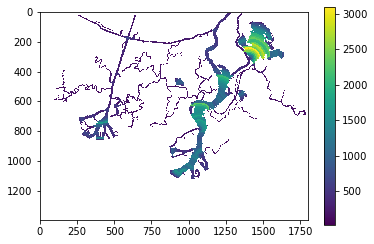

In [31]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths)
plt.colorbar()

In [32]:
rivG = add_width_features_to_graph(rivG, width_features.ravel())

# Obtaining Candidate Width Geometries

First, we add flow attributes as dictated above.

In [33]:
rivG = add_flow_attributes(rivG, dist, profile['transform'])

flow vector computation using network: 100%|██████████| 1277/1277 [00:00<00:00, 7935.51it/s]


Observe the new attributes in the node data:

In [34]:
node_data =dict(rivG.nodes(data=True))
random.choice(list(node_data.items()))

((667087.3245251857, 3261222.068538398),
 {'label': 1376,
  'meters_to_interface': 3656.904100622046,
  'x': 667087.3245251857,
  'y': 3261222.068538398,
  'interface_adj': False,
  'graph_degree': 3,
  'cc_id': 0,
  'width_from_segment': 1361.5424623862048,
  'flow_vector_perp_grad': (-0.076281615, -0.9970863),
  'flow_vector_network': (0.3139663990531889, 0.7301951262670873),
  'flow_vector_perp_network': (-0.7301951262670873, 0.3139663990531889),
  'flow_vector_perp': (-0.076281615, -0.9970863)})

Let's obtain the segment geometries and the relevant metadata.

In [35]:
df_segments = get_segment_df(segments, rivG, profile)
df_segments.head()

,label,geometry,perimeter,node,flow_vector_perp
0,1,"POLYGON ((674525 3285050, 674525 3284975, 6745...",1050.0,"(674639.9253731343, 3284979.850746269)","(-0.8390924, 0.543989)"
1,2,"POLYGON ((672525 3285025, 672525 3285000, 6725...",1400.0,"(672644.298245614, 3284918.201754386)","(-0.72057915, 0.6933727)"
2,3,"POLYGON ((672750 3285025, 672750 3285000, 6727...",500.0,"(672825.0, 3284997.0588235296)","(-0.64216274, 0.7665683)"
3,4,"POLYGON ((672200 3285000, 672200 3284975, 6721...",1900.0,"(672396.7914438503, 3284829.679144385)","(-0.74255943, 0.6697802)"
4,5,"POLYGON ((674475 3284950, 674475 3284900, 6744...",1300.0,"(674478.2738095238, 3284817.5595238097)","(-0.873712, 0.48644358)"


We will save these as a shapefile for posterity.

In [36]:
df_segments_out = change_tuples_to_vector(df_segments)
df_segments_out.to_file(products_for_map_dir/'segments.geojson', 
                        driver='GeoJSON')

This is the expensive computation regarding intersections. We use multithreading, but we suspect there are ways to improve this.

In [37]:
%%time

df_geo_widths = get_geo_width_df(df_segments, rivG, radius=2)
df_geo_widths.head()

CPU times: user 7.48 s, sys: 32.2 ms, total: 7.52 s
Wall time: 7.52 s


,label,node,geometry,width_m
0,1,"(674639.9253731343, 3284979.850746269)","LINESTRING (674531.721508837 3285050.00001, 67...",230.342346
1,2,"(672644.298245614, 3284918.201754386)","LINESTRING (672533.3094613238 3285025.00001, 6...",335.411530
2,3,"(672825.0, 3284997.0588235296)","LINESTRING (672801.5933592657 3285025.00001, 6...",114.311598
3,4,"(672396.7914438503, 3284829.679144385)","LINESTRING (672207.9632784519 3285000.00001, 6...",522.559530
4,5,"(674478.2738095238, 3284817.5595238097)","LINESTRING (674399.99999 3284861.138868932, 67...",228.472293


Let's save the geometry to a file

In [38]:
df_geo_widths_out = change_tuples_to_vector(df_geo_widths)
df_geo_widths_out.to_file(products_for_map_dir/'width_geometries.geojson', 
                      driver='GeoJSON')

Updating the graph and inspecting the attributes.

In [39]:
rivG = update_graph_with_geometric_width_data(rivG, df_geo_widths)

We see we have `width_m` in the node data.

In [40]:
node_data =dict(rivG.nodes(data=True))
random.choice(list(node_data.items()))

((644484.2105263158, 3270670.3947368423),
 {'label': 886,
  'meters_to_interface': 22522.625658877198,
  'x': 644484.2105263158,
  'y': 3270670.3947368423,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'width_from_segment': 125.0,
  'flow_vector_perp_grad': None,
  'flow_vector_network': (-0.992754017851482, -0.1015096969765367),
  'flow_vector_perp_network': (0.1015096969765367, -0.992754017851482),
  'flow_vector_perp': (0.1015096969765367, -0.992754017851482),
  'width_from_geometry': 125.65177010581644})

## Final Width Determination

In [41]:
trans = profile['transform']
res = trans.a
res

25.0

In [42]:
rivG = update_graph_with_widths(rivG,
                                resolution=res,
                                relative_width_buffer=np.sqrt(2), 
                                absolute_width_cutoff=500)

# Save Network

First, we export each of the graphs to Geopandas `GeoDataFrame`.

In [43]:
df_nodes = export_nodes_to_geodataframe(rivG, profile['crs'])
df_nodes = change_tuples_to_vector(df_nodes)
df_edges = export_edges_to_geodataframe(rivG, profile['crs'])

For example, the edge attributes are now columns in a dataframe.

In [44]:
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,width_m,geometry
0,238.516385,238.516385,0,10,0,506.753751,LINESTRING (649898.4693877551 3267811.32653061...
1,255.181139,255.181139,0,10,0,525.079650,LINESTRING (649661.0745614035 3267834.42982456...
2,252.497707,252.497707,0,10,0,470.220618,LINESTRING (649408.8157894737 3267795.92105263...
3,266.893075,266.893075,0,10,0,482.167537,LINESTRING (649169.3681318681 3267715.79670329...
4,244.409188,244.409188,0,10,0,456.697005,LINESTRING (648904.5138888889 3267682.87037037...


We save these using the geopandas ecosystem. We used `geojson` because some of our column names are long and shapefiles have a 10 character limit. However, removing the `driver` keyword (the shapefile is default), saves the above dataframe to an ESRI Shapfile.

In [45]:
df_nodes.head()

,label,meters_to_interface,x,y,interface_adj,graph_degree,cc_id,width_from_segment,width_from_geometry,width_m,flow_vector_perp_grad_x,flow_vector_perp_grad_y,flow_vector_network_x,flow_vector_network_y,flow_vector_perp_network_x,flow_vector_perp_network_y,flow_vector_perp_x,flow_vector_perp_y,geometry
0,1128,2518.079724,649898.469388,3.267811e+06,False,3,0,422.213595,434.090320,434.090320,-0.310660,0.950521,0.866315,0.252445,-0.252445,0.866315,-0.310660,0.950521,POINT (649898.4693877551 3267811.326530612)
1,1136,2279.563340,649661.074561,3.267834e+06,False,2,0,525.000000,579.417181,579.417181,-0.314584,0.949230,0.992037,0.022841,-0.022841,0.992037,-0.314584,0.949230,POINT (649661.0745614035 3267834.429824561)
2,1143,2024.382201,649408.815789,3.267796e+06,False,2,0,449.341649,470.742120,470.742120,-0.293570,0.955937,0.968326,0.234557,-0.234557,0.968326,-0.293570,0.955937,POINT (649408.8157894737 3267795.921052631)
3,1154,1771.884494,649169.368132,3.267716e+06,False,2,0,435.977223,469.699117,469.699117,-0.286567,0.958060,0.969728,0.223036,-0.223036,0.969728,-0.286567,0.958060,POINT (649169.3681318681 3267715.796703297)
4,1145,1504.991419,648904.513889,3.267683e+06,False,2,0,425.000000,494.635957,494.635957,-0.278962,0.960302,0.900718,0.360121,-0.360121,0.900718,-0.278962,0.960302,POINT (648904.5138888889 3267682.87037037)


In [46]:
df_edges.to_file(products_for_map_dir/'orinoco_edges.geojson', driver='GeoJSON')
df_nodes.to_file(products_for_map_dir/'orinoco_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(rivG, products_for_map_dir/'river_network.pkl')

And if you wish to check the direction of flow in QGIS, use this [feature](https://gis.stackexchange.com/a/215842/114646). 